In [1]:
#remove rmse values altogether - focus on underprediction ratio (for pie charts)
#learn what the clustering [0] means

#slide 1 - fugaku dataset and feature selection (objectives)
#slide 2 - explaining underprediction ratio, RF model
#slide 3 - hyperparameter tuning - negative results
#slide 4 - frequency analysis
#slide 5 - pie chart analysis, explaining MLP,Sequential and Cluster model
#slide 7 - execution time - 4 pie charts (4 models)
#slide 8 - number of cores - 4 pie charts
#slide 9 - memory size - 4 pie charts

#Learn:
#fugaku dataset column meanings
#RF model
#MLP model
#how sequential model works
#how clustering works
#ravel(), standardization, frequency

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
#r2_score range -> 1 to negative
#1 - best fit, 0 to negative - not applicable
from sklearn.metrics import accuracy_score, r2_score 
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tabulate import tabulate
import numpy as np

In [7]:
april2024_data = pd.read_parquet("24_04.parquet")
april2024_data = april2024_data[april2024_data["exit state"] == "completed"]
april2024_data.head()

,jid,usr,jnam,cnumr,cnumat,cnumut,nnumr,adt,qdt,schedsdt,...,jobenv_req,freq_req,freq_alloc,flops,mbwidth,opint,pclass,embedding,exit state,duration
8,jid_23119026,usr_2771,jnam_2301971,48,48,48,1,2024-04-07 01:36:14+09,2024-04-07 01:36:14+09,2024-04-07 01:36:14+09,...,jobenv_req_1,2000,2000,6.541158e+09,2.310258e+10,0.283135,memory-bound,"[-0.07739889, -0.01745062, -0.06704966, -0.004...",completed,3129.0
9,jid_23119027,usr_3004,jnam_73059,144,144,144,3,2024-04-05 18:17:10+09,2024-04-05 18:17:10+09,2024-04-07 02:00:57+09,...,jobenv_req_1,2000,2000,1.909095e+11,6.373276e+11,0.299547,memory-bound,"[-0.0914019, 0.03826673, -0.027243994, -0.0132...",completed,1647.0
17,jid_23119035,usr_1839,jnam_2301975,48,48,20,1,2024-04-07 22:31:26+09,2024-04-07 22:31:26+09,2024-04-07 22:31:26+09,...,jobenv_req_1,2000,2000,1.318028e+04,4.986295e+08,0.000026,memory-bound,"[-0.121330984, -0.015676264, -0.05872378, -0.0...",completed,3.0
21,jid_23119035,usr_1839,jnam_2301975,48,48,20,1,2024-04-07 22:31:26+09,2024-04-07 22:31:26+09,2024-04-07 22:31:26+09,...,jobenv_req_1,2000,2000,1.322449e+04,6.481916e+08,0.000020,memory-bound,"[-0.121330984, -0.015676264, -0.05872378, -0.0...",completed,3.0
27,jid_23119035,usr_1839,jnam_2301975,48,48,20,1,2024-04-07 22:31:26+09,2024-04-07 22:31:26+09,2024-04-07 22:31:26+09,...,jobenv_req_1,2000,2000,1.317837e+04,7.016042e+08,0.000019,memory-bound,"[-0.121330984, -0.015676264, -0.05872378, -0.0...",completed,3.0


In [9]:
#sorting the dataset by the 'adt' column
april2024_data['adt'] = pd.to_datetime(april2024_data['adt'])
april2024_data = april2024_data.sort_values(by='adt', ascending=True)
april2024_data = april2024_data.reset_index(drop=True)
#gives the week number
april2024_data['week'] = april2024_data['adt'].dt.isocalendar().week
#april2021_data.head()

In [11]:
april2024_data['week'] = april2024_data['week'].fillna(-1)
unique_weeks = sorted(april2024_data['week'].unique())
#print(unique_weeks)

In [13]:
#EXECUTION TIME
#dont use jid
input_exec_time = ['usr', 'jnam', 'mszl', 'cnumr', 'nnumr', 'freq_req', 'elpl']
output_exec_time = ['duration']

#using label encoding for the string datatype columns
label_encoders = {}
for col in [ 'usr', 'jnam']:
    le = LabelEncoder()
    april2024_data[col] = le.fit_transform(april2024_data[col])
    #storing label encoders if required later
    label_encoders[col] = le

y_test_all_exec_time = []
y_pred_all_exec_time_RF = []
y_pred_all_exec_time_MLP = []

In [15]:
#data splitting(with replacement) - bootstrapping -> every decision tree trained indiviually
#n_estimators - number of trees - majority of all the decisions
#random_state - shuffle
RF_model = RandomForestRegressor(n_estimators=100, random_state=42)

#Weights represent the importance of each input
MLP_NN_model = MLPRegressor(hidden_layer_sizes=(4,),  # 1 hidden layer with 4 neurons (any number of neuron layers possible)
                   activation='relu',        # ReLU activation function - whether a neuron should be activated based on the weighter sum of inputs.
                   solver='adam',            # Adam optimizer - how the network updates its weights during training
                   learning_rate_init=0.1,   # Learning rate - how quickly the model learns
                   max_iter=5000,            # Training iterations
                   random_state=42)

In [95]:
total_low_RF = 0       
total_mid_RF = 0       
total_high_RF = 0 
total_low_MLP = 0       
total_mid_MLP = 0       
total_high_MLP = 0 

In [97]:
for week in sorted(unique_weeks):
    weekly_data = april2024_data[april2024_data['week'] == week]
    
    X = weekly_data[input_exec_time]
    Y = weekly_data[output_exec_time]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)
    Y_train = Y_train.values.ravel()

    RF_model = RandomForestRegressor(random_state=33)
    RF_model.fit(X_train, Y_train)
    Y_pred_RF = RF_model.predict(X_test)

    MLP_NN_model.fit(X_train, Y_train)
    Y_pred_MLP = MLP_NN_model.predict(X_test)

    y_test_all_exec_time.extend(Y_test.values)
    y_pred_all_exec_time_RF.extend(Y_pred_RF)
    y_pred_all_exec_time_MLP.extend(Y_pred_MLP)

    ratios = Y_pred_RF / Y_test.values
    low = np.sum(ratios < 0.85)
    mid = np.sum((ratios >= 0.85) & (ratios < 1.15))
    high = np.sum(ratios >= 1.15)

    total_low_RF += low
    total_mid_RF += mid
    total_high_RF += high

    ratios = Y_pred_MLP / Y_test.values
    low = np.sum(ratios < 0.85)
    mid = np.sum((ratios >= 0.85) & (ratios < 1.15))
    high = np.sum(ratios >= 1.15)

    total_low_MLP += low
    total_mid_MLP += mid
    total_high_MLP += high  

In [43]:
up_rf = [
    (actual, predicted) for actual, predicted in zip(y_test_all_exec_time, y_pred_all_exec_time_RF) 
    if predicted < actual
]
num_up_rf = len(up_rf)
total_rf = len(y_test_all_exec_time)
#Underprediction ratio for RF model (frequency: 1 week)
up_ratio_rf = (num_up_rf / total_rf) * 100

In [45]:
print (up_ratio_rf)

46.090729317316494


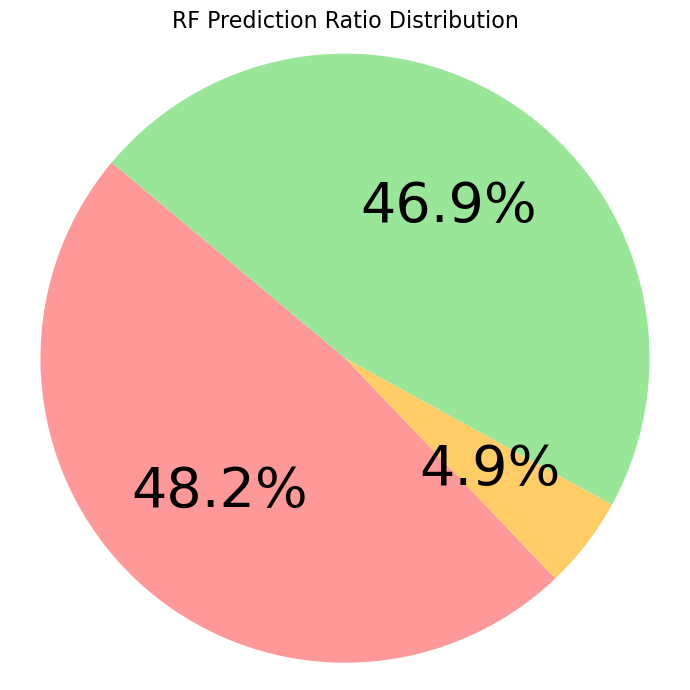

In [161]:
sizes = [total_low_RF, total_mid_RF, total_high_RF]
darker_colors = ['#ff9999', '#ffcc66', '#99e699']  # Darker red-yellow-green tones

plt.figure(figsize=(7, 7))
plt.pie(
    sizes, 
    colors=darker_colors, 
    autopct=lambda pct: f'{pct:.1f}%',  # keep 1 decimal point
    startangle=140,
    textprops={'fontsize': 40}  # Larger font size for labels and percentages
)
plt.title('RF Prediction Ratio Distribution', fontsize=16)
plt.axis('equal')  # Ensures the pie is a circle
plt.tight_layout()
plt.show()

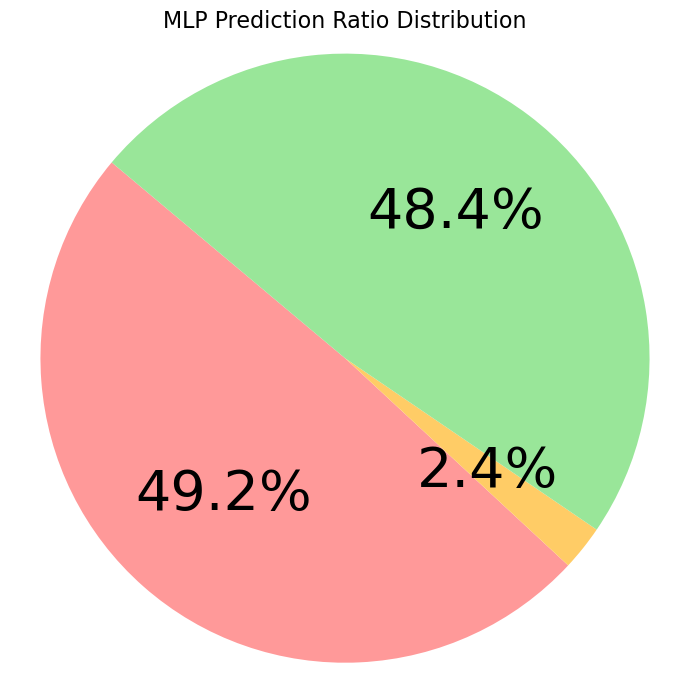

In [163]:
sizes = [total_low_MLP, total_mid_MLP, total_high_MLP]
darker_colors = ['#ff9999', '#ffcc66', '#99e699']  # Darker red-yellow-green tones

plt.figure(figsize=(7, 7))
plt.pie(
    sizes, 
    colors=darker_colors, 
    autopct=lambda pct: f'{pct:.1f}%',  # keep 1 decimal point
    startangle=140,
    textprops={'fontsize': 40}  # Larger font size for labels and percentages
)
plt.title('MLP Prediction Ratio Distribution', fontsize=16)
plt.axis('equal')  # Ensures the pie is a circle
plt.tight_layout()
plt.show()

In [51]:
start_date = april2024_data['adt'].min()
end_date = april2024_data['adt'].max()
date_ranges = pd.date_range(start=start_date, end=end_date, freq='3D')

y_test_3D_all_exec_time = []
y_pred_3D_all_exec_time_RF = []
y_pred_3D_all_exec_time_MLP = []

In [53]:
RF_model2 = RandomForestRegressor(n_estimators=100, random_state=42)

MLP_NN_model2 = MLPRegressor(hidden_layer_sizes=(4,),  
                   activation='relu',        
                   solver='adam',            
                   learning_rate_init=0.1,   
                   max_iter=5000,            
                   random_state=42)

In [55]:
for start in date_ranges:
    end = start + pd.Timedelta(days=2)  # 3-day window (start, start+1, start+2)
    
    # Filter data for the current 3-day window
    mask = (april2024_data['adt'] >= start) & (april2024_data['adt'] <= end)
    three_day_data = april2024_data[mask]
    
    if three_day_data.empty:
        continue  # Skip if no data for the 3-day period

    X = three_day_data[input_exec_time]
    Y = three_day_data[output_exec_time]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)
    Y_train = Y_train.values.ravel()
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    RF_model2.fit(X_train_scaled, Y_train)
    Y_pred_RF = RF_model2.predict(X_test_scaled)

    MLP_NN_model2.fit(X_train_scaled, Y_train)
    Y_pred_MLP = MLP_NN_model2.predict(X_test_scaled)

    y_test_3D_all_exec_time.extend(Y_test.values)
    y_pred_3D_all_exec_time_RF.extend(Y_pred_RF)
    y_pred_3D_all_exec_time_MLP.extend(Y_pred_MLP)

In [57]:
date_ranges = pd.date_range(start=start_date, end=end_date, freq='2D')
y_test_1D_all_exec_time = []
y_pred_1D_all_exec_time_RF = []
y_pred_1D_all_exec_time_MLP = []

In [59]:
RF_model3 = RandomForestRegressor(n_estimators=100, random_state=42)

MLP_NN_model3 = MLPRegressor(hidden_layer_sizes=(4,),  
                   activation='relu',        
                   solver='adam',            
                   learning_rate_init=0.1,   
                   max_iter=5000,            
                   random_state=42)

In [61]:
for start in date_ranges:
    end = start + pd.Timedelta(days=1) 

    # Filter data for the current 2-day window
    mask = (april2024_data['adt'] >= start) & (april2024_data['adt'] <= end)
    one_day_data = april2024_data[mask]
    
    if one_day_data.empty:
        continue  # Skip if no data for the 2-day period


    X = one_day_data[input_exec_time]
    Y = one_day_data[output_exec_time]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)
    Y_train = Y_train.values.ravel()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    RF_model3.fit(X_train_scaled, Y_train)
    Y_pred_RF = RF_model3.predict(X_test_scaled)

    MLP_NN_model3.fit(X_train_scaled, Y_train)
    Y_pred_MLP = MLP_NN_model3.predict(X_test_scaled)

    y_test_1D_all_exec_time.extend(Y_test.values)
    y_pred_1D_all_exec_time_RF.extend(Y_pred_RF)
    y_pred_1D_all_exec_time_MLP.extend(Y_pred_MLP)

In [63]:
up_1D_rf = [
    (actual, predicted) for actual, predicted in zip(y_test_1D_all_exec_time, y_pred_1D_all_exec_time_RF) 
    if predicted < actual
]
num_up_1D_rf = len(up_1D_rf)
total_1D_rf = len(y_test_1D_all_exec_time)
#Underprediction ratio for RF model (frequency: 2 days)
up_ratio_1D_rf = (num_up_1D_rf / total_1D_rf) * 100

up_3D_rf = [
    (actual, predicted) for actual, predicted in zip(y_test_3D_all_exec_time, y_pred_3D_all_exec_time_RF) 
    if predicted < actual
]
num_up_3D_rf = len(up_3D_rf)
total_3D_rf = len(y_test_3D_all_exec_time)
#Underprediction ratio for RF model (frequency: 3 days)
up_ratio_3D_rf = (num_up_3D_rf / total_3D_rf) * 100

In [65]:
data = {
    "Metric": [ "Underprediction Ratio (%)"],
    "RF Model (1 Week Frequency)": [ up_ratio_rf],
    "RF Model (3 Days Frequency)": [ up_ratio_3D_rf],
    "RF Model (2 Days Frequency)": [ up_ratio_1D_rf]
}

RF_exec_time_df = pd.DataFrame(data)
RF_exec_time_df = RF_exec_time_df.round(2)
print(tabulate(RF_exec_time_df, headers='keys', tablefmt='pretty', showindex=False))

+---------------------------+-----------------------------+-----------------------------+-----------------------------+
|          Metric           | RF Model (1 Week Frequency) | RF Model (3 Days Frequency) | RF Model (2 Days Frequency) |
+---------------------------+-----------------------------+-----------------------------+-----------------------------+
| Underprediction Ratio (%) |            46.09            |            40.15            |            39.51            |
+---------------------------+-----------------------------+-----------------------------+-----------------------------+


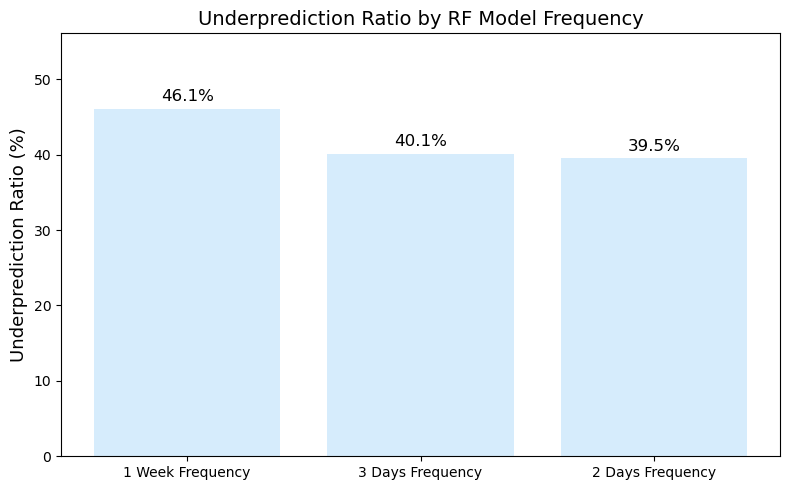

In [67]:
models = ["1 Week Frequency", "3 Days Frequency", "2 Days Frequency"]
ratios = [up_ratio_rf, up_ratio_3D_rf, up_ratio_1D_rf]
bar_color = '#d6ecfc' 
plt.figure(figsize=(8, 5))
bars = plt.bar(models, ratios, color=bar_color)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', fontsize=12)
plt.ylabel("Underprediction Ratio (%)", fontsize=13)
plt.title("Underprediction Ratio by RF Model Frequency", fontsize=14)
plt.ylim(0, max(ratios) + 10)
plt.tight_layout()
plt.show()

In [69]:
from sklearn.model_selection import GridSearchCV
#hyperparameter tuning using grid_search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
grid_search = GridSearchCV(RF_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, Y_train)

print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [71]:
#Other ways to tune hyperparameters:
#grid search - searches over fixed grid of hyperparameters
#random search - selects random subsets (may miss the optimal combination)
#BayesSearch - probabilistic modeling

In [73]:
RF_model.set_params(**grid_search.best_params_)

RandomForestRegressor(min_samples_split=5, n_estimators=200, random_state=33)

In [75]:
y_test_all_tuned_exec_time = []
y_pred_all_tuned_exec_time_RF = []

In [79]:
for week in sorted(unique_weeks):
    weekly_data = april2024_data[april2024_data['week'] == week]
    
    X = weekly_data[input_exec_time]
    Y = weekly_data[output_exec_time]
    
    # Train-test split (80% train, 20% test)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)
    Y_train = Y_train.values.ravel()
    
    # Standardize training data only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    RF_model.fit(X_train_scaled, Y_train)
    Y_pred_RF = RF_model.predict(X_test_scaled)

    y_test_all_tuned_exec_time.extend(Y_test.values)
    y_pred_all_tuned_exec_time_RF.extend(Y_pred_RF)

In [81]:
up_tuned_rf = [
    (actual, predicted) for actual, predicted in zip(y_test_all_tuned_exec_time, y_pred_all_tuned_exec_time_RF) 
    if predicted < actual
]
num_up_tuned_rf = len(up_tuned_rf)
total_tuned_rf = len(y_test_all_tuned_exec_time)
#Underprediction value for hypertuned RF model
up_ratio_tuned_rf = (num_up_tuned_rf/ total_tuned_rf) * 100

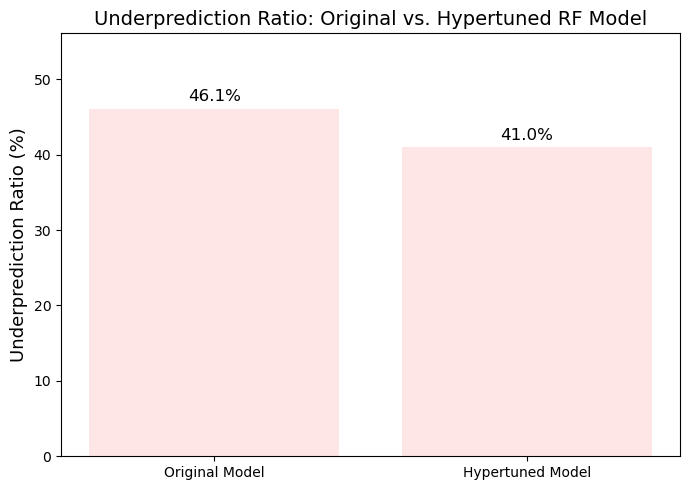

In [91]:
models = ["Original Model", "Hypertuned Model"]
ratios = [up_ratio_rf, up_ratio_tuned_rf]

bar_color = '#ffe6e6'
plt.figure(figsize=(7, 5))
bars = plt.bar(models, ratios, color=bar_color)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', fontsize=12)

plt.ylabel("Underprediction Ratio (%)", fontsize=13)
plt.title("Underprediction Ratio: Original vs. Hypertuned RF Model", fontsize=14)
plt.ylim(0, max(ratios) + 10)
plt.tight_layout()
plt.show()

In [103]:
from sklearn.cluster import KMeans

In [105]:
RF_cluster_0 = RandomForestRegressor(n_estimators=100, random_state=42)
RF_cluster_1 = RandomForestRegressor(n_estimators=100, random_state=42)
RF_cluster_2 = RandomForestRegressor(n_estimators=100, random_state=42)

In [107]:
y_test_all_cluster = []
y_pred_all_cluster = []

In [111]:
total_low_cluster = 0
total_mid_cluster = 0
total_high_cluster = 0

In [121]:
for week in sorted(unique_weeks):
    weekly_data = april2024_data[april2024_data['week'] == week]
    X = weekly_data[input_exec_time]
    Y = weekly_data[output_exec_time]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False, random_state=42)
    Y_train = Y_train.values.ravel()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
    train_clusters = kmeans.fit_predict(X_train_scaled)

    RF_cluster_0.fit(X_train_scaled[train_clusters == 0], Y_train[train_clusters == 0])
    RF_cluster_1.fit(X_train_scaled[train_clusters == 1], Y_train[train_clusters == 1])
    RF_cluster_2.fit(X_train_scaled[train_clusters == 2], Y_train[train_clusters == 2])

    test_clusters = kmeans.predict(X_test_scaled)

    for i, cluster_id in enumerate(test_clusters):
        x_sample = X_test_scaled[i].reshape(1, -1)
        y_true = Y_test.values[i]

        if cluster_id == 0:
            y_pred = RF_cluster_0.predict(x_sample)[0]
        elif cluster_id == 1:
            y_pred = RF_cluster_1.predict(x_sample)[0]
        else:
            y_pred = RF_cluster_2.predict(x_sample)[0]

        y_test_all_cluster.append(y_true)
        y_pred_all_cluster.append(y_pred)

        ratios = y_pred / y_true
        if ratios < 0.85:
            total_low_cluster += 1
        elif 0.85 <= ratios < 1.15:
            total_mid_cluster += 1
        else:
            total_high_cluster += 1

In [123]:
up_cluster = [
    (actual, predicted) for actual, predicted in zip(y_test_all_cluster, y_pred_all_cluster) 
    if predicted < actual
]
num_up_cluster = len(up_cluster)
total_cluster = len(y_test_all_cluster)
#Underprediction ratio for RF model (frequency: 1 week)
up_ratio_cluster = (num_up_cluster / total_cluster) * 100

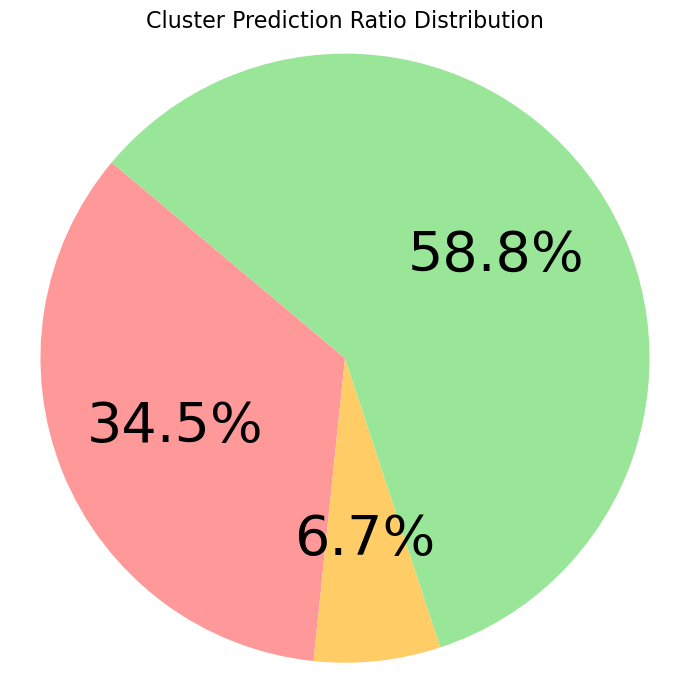

In [165]:
sizes = [total_low_cluster, total_mid_cluster, total_high_cluster]
darker_colors = ['#ff9999', '#ffcc66', '#99e699']  # Darker red-yellow-green tones

plt.figure(figsize=(7, 7))
plt.pie(
    sizes, 
    colors=darker_colors, 
    autopct=lambda pct: f'{pct:.1f}%',  # keep 1 decimal point
    startangle=140,
    textprops={'fontsize': 40}  # Larger font size for labels and percentages
)
plt.title('Cluster Prediction Ratio Distribution', fontsize=16)
plt.axis('equal')  # Ensures the pie is a circle
plt.tight_layout()
plt.show()

In [129]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [131]:
seq_model = Sequential([
    Dense(4, activation='relu', input_shape=(X_train.shape[1],)),  # 1 hidden layer with 4 neurons
    Dense(1)  # Output layer with 1 neuron for regression
])

/Users/nishthaladi/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [133]:
y_test_all_exec_time_seq = []
y_pred_all_exec_time_seq = []

In [135]:
total_low_seq= 0
total_mid_seq = 0
total_high_seq = 0

In [141]:
for week in sorted(unique_weeks):
    weekly_data = april2024_data[april2024_data['week'] == week]

    X = weekly_data[input_exec_time]
    Y = weekly_data[output_exec_time]

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, shuffle=False
    )
    Y_train = Y_train.values.ravel()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    seq_model.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error')

    seq_model.fit(X_train_scaled, Y_train, epochs=50, verbose=0)

    Y_pred_SEQ = seq_model.predict(X_test_scaled).flatten() 

    y_test_all_exec_time_seq.extend(Y_test.values)
    y_pred_all_exec_time_seq.extend(Y_pred_SEQ)

    for i in range(len(Y_test)):
        y_true = Y_test.values[i]
        y_pred = Y_pred_SEQ[i]

        y_test_all_exec_time_seq.append(y_true)
        y_pred_all_exec_time_seq.append(y_pred)

        ratio = y_pred / y_true

        if ratio < 0.85:
            total_low_seq += 1
        elif 0.85 <= ratio < 1.15:
            total_mid_seq += 1
        else:
            total_high_seq += 1

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
745/745 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


In [143]:
up_seq = [
    (actual, predicted) for actual, predicted in zip(y_test_all_exec_time_seq, y_pred_all_exec_time_seq) 
    if predicted < actual
]
num_up_seq = len(up_seq)
total_seq = len(y_test_all_exec_time_seq)
#Underprediction ratio for RF model (frequency: 1 week)
up_ratio_seq = (num_up_seq / total_seq) * 100

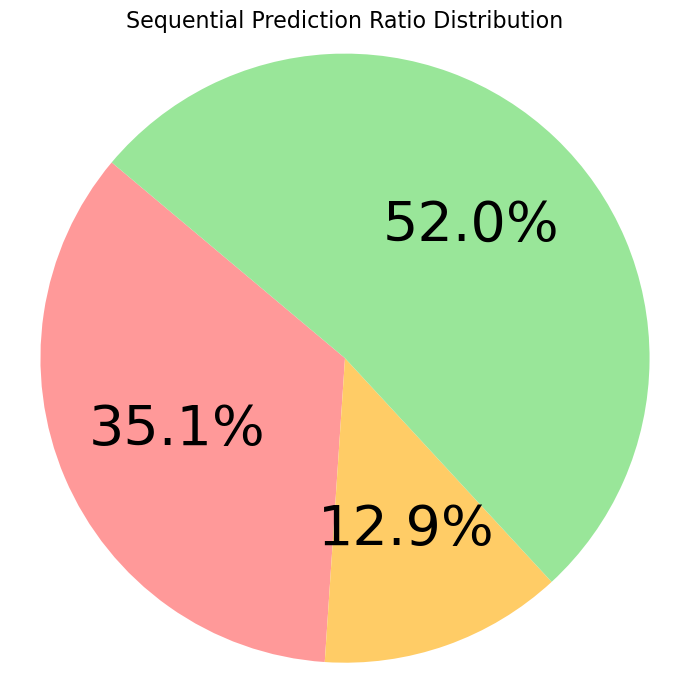

In [167]:
sizes = [total_low_seq, total_mid_seq, total_high_seq]
darker_colors = ['#ff9999', '#ffcc66', '#99e699']  # Darker red-yellow-green tones

plt.figure(figsize=(7, 7))
plt.pie(
    sizes, 
    colors=darker_colors, 
    autopct=lambda pct: f'{pct:.1f}%',  # keep 1 decimal point
    startangle=140,
    textprops={'fontsize': 40}  # Larger font size for labels and percentages
)
plt.title('Sequential Prediction Ratio Distribution', fontsize=16)
plt.axis('equal')  # Ensures the pie is a circle
plt.tight_layout()
plt.show()